In [7]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [8]:
import os
import random
from PIL import Image, ImageOps, ImageEnhance
from torchvision import transforms

input_folder = 'C:/Users/ishitv/Desktop/jvdskg/train_data'
output_folder = 'C:/Users/ishitv/Desktop/jvdskg/augment_data'


# Create the output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Define transformations for each effect
flip_horizontal = transforms.RandomHorizontalFlip(p=1.0)  
flip_vertical = transforms.RandomVerticalFlip(p=1.0)      
rotate = transforms.RandomRotation(degrees=15)            
color_jitter = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)  

# Function to randomly drop some part of the image (random crop)
def random_crop(image):
    width, height = image.size
    crop_ratio = random.uniform(0.7, 0.9)  # Randomly crop between 70%-90% of the image
    new_width = int(width * crop_ratio)
    new_height = int(height * crop_ratio)
    left = random.randint(0, width - new_width)
    top = random.randint(0, height - new_height)
    return image.crop((left, top, left + new_width, top + new_height)).resize((width, height))

# Function to apply and save different effects
def apply_effects(img, filename):
    # Apply horizontal flip
    img_flip_h = flip_horizontal(img)
    img_flip_h.save(os.path.join(output_folder, f"{filename.split('.')[0]}_flip_h.{filename.split('.')[1]}"))

    # Apply vertical flip
    img_flip_v = flip_vertical(img)
    img_flip_v.save(os.path.join(output_folder, f"{filename.split('.')[0]}_flip_v.{filename.split('.')[1]}"))

    # Apply rotation
    img_rotated = rotate(img)
    img_rotated.save(os.path.join(output_folder, f"{filename.split('.')[0]}_img_rot.{filename.split('.')[1]}"))

    # Apply color jitter
    img_color_jittered = color_jitter(img)
    img_color_jittered.save(os.path.join(output_folder, f"{filename.split('.')[0]}_col_jit.{filename.split('.')[1]}"))

    # Apply random crop
    img_cropped = random_crop(img)
    img_cropped.save(os.path.join(output_folder, f"{filename.split('.')[0]}_crop.{filename.split('.')[1]}"))

# Load and augment images
for filename in os.listdir(input_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)

        # Apply different effects and save them as new images
        apply_effects(img, filename)

        print(f"Generated 5 images from {filename} in {output_folder}")


Generated 5 images from 10_image_04081.jpg in C:/Users/ishitv/Desktop/jvdskg/augment_data
Generated 5 images from 10_image_04082.jpg in C:/Users/ishitv/Desktop/jvdskg/augment_data
Generated 5 images from 10_image_04083.jpg in C:/Users/ishitv/Desktop/jvdskg/augment_data
Generated 5 images from 10_image_04084.jpg in C:/Users/ishitv/Desktop/jvdskg/augment_data
Generated 5 images from 10_image_04085.jpg in C:/Users/ishitv/Desktop/jvdskg/augment_data
Generated 5 images from 10_image_04086.jpg in C:/Users/ishitv/Desktop/jvdskg/augment_data
Generated 5 images from 10_image_04087.jpg in C:/Users/ishitv/Desktop/jvdskg/augment_data
Generated 5 images from 10_image_04088.jpg in C:/Users/ishitv/Desktop/jvdskg/augment_data
Generated 5 images from 10_image_04089.jpg in C:/Users/ishitv/Desktop/jvdskg/augment_data
Generated 5 images from 10_image_04090.jpg in C:/Users/ishitv/Desktop/jvdskg/augment_data
Generated 5 images from 10_image_04091.jpg in C:/Users/ishitv/Desktop/jvdskg/augment_data
Generated 

In [1]:
import cv2
import os
from skimage import feature

def read_images_and_labels(img_dir, label_file):
    # Read the labels from the label file
    with open(label_file) as f:
        labels = [word.lower().strip() for word in f.read().split("\n") if word.strip()]

    # Create a mapping of label to its index

    labels = [eval(i) for i in labels]
    # print(max(labels))
    list_set = set(labels)
    corrected_labels = (list(list_set))
    # print(max(corrected_labels))
    
    final_data=[]
    
    for label in set(corrected_labels):
       
        matching_files = [f for f in os.listdir(img_dir) if f.startswith(f"{label}_image_") and f.endswith('.jpg')]
        
        # Read each matching image
        for matching_file in matching_files:
            image_path = os.path.join(img_dir, matching_file)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            (hog, image) = feature.hog(image, orientations=9, 
                    pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                    block_norm='L2-Hys', visualize=True, transform_sqrt=True)
            if image is not None:
                final_data.append((image,label-1))

    return final_data


In [2]:

path ="C:/Users/ishitv/Desktop/jvdskg/augment_data"
path1 ="C:/Users/ishitv/Desktop/jvdskg/train_labels.txt"
images_data= read_images_and_labels(path,path1)
len(images_data)

15000

In [3]:
path ="C:/Users/ishitv/Desktop/jvdskg/val_data"
path1 ="C:/Users/ishitv/Desktop/jvdskg/val_labels.txt"
val_data= read_images_and_labels(path,path1)
len(val_data)

600

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from joblib import dump, load
import numpy as np
import torch

def perform_pca_and_plot_variance(data,input_list):
    #Flatten images and prepare feature array
    features = []
    labels = []
    val_pixel=[]
    val_label=[]
    
    for (image, label) in data:
        # Flatten the image from (256, 256, 3) to (256*256*3,)
        np_array = np.array(image, dtype=np.float32)
        flattened_image=torch.tensor(np_array)
        flattened_image = flattened_image.reshape(1,-1)
        
        features.append(flattened_image[0])
        labels.append(label)  

    features=torch.stack(features, dim=0)
    X = np.array(features)
    
    for (image, label) in input_list:
        # Flatten the image from (256, 256, 3) to (256*256*3,)
        np_array = np.array(image, dtype=np.float32)
        flattened_image=torch.tensor(np_array)
        flattened_image = flattened_image.reshape(1,-1)
        
        val_pixel.append(flattened_image[0])
        val_label.append(label)  # You can keep this if needed

    # Convert to a 2D NumPy array
    val_pixel=torch.stack(val_pixel, dim=0)
        
    input_array = np.array(val_pixel) 

    #Perform PCA
    pca = PCA()
    pca.fit(X)

    #Calculate cumulative variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    #Plot cumulative variance vs number of components
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.title('Cumulative Explained Variance vs Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.axhline(y=0.95, color='r', linestyle='--') 
    plt.text(0.5, 0.9, '95% Threshold', color='r')
    plt.show()
    
    #pca reduction
    variance_threshold=0.95
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    print(f"Number of components to retain {variance_threshold*100:.0f}% variance: {n_components}")

    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    pca_result = pca.transform(input_array)
    
    dump(pca, 'pca_object.joblib')

    return X_reduced,labels,pca_result,val_label
    


15000


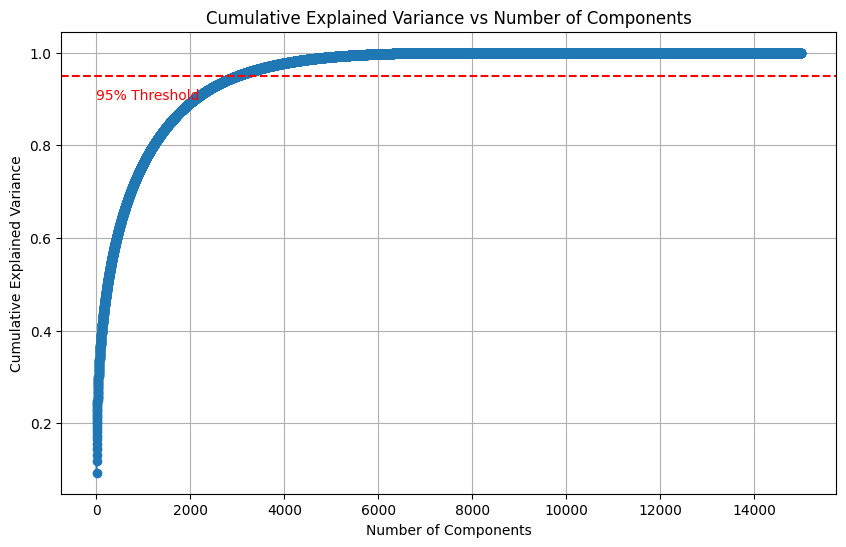

Number of components to retain 95% variance: 2997


In [11]:
print(len(images_data))

images_data,labels,data_val,label_val=perform_pca_and_plot_variance(images_data,val_data)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np


X_train= np.array(images_data)
X_val= np.array(data_val)
y_train= np.array(labels)
y_val= np.array(label_val)

y_train = to_categorical(y_train, num_classes=60)
y_val = to_categorical(y_val, num_classes=60)


model = Sequential()
# model.add(Flatten(input_shape=(256, 256, 1)))
model.add(Dense(2048, activation="relu"))
model.add(Dropout(0.5))  
model.add(BatchNormalization())

model.add(Dense(1024, activation="relu"))
model.add(BatchNormalization())

model.add(Dense(1024, activation="relu"))
model.add(BatchNormalization())

model.add(Dense(512, activation="relu"))

model.add(Dense(256, activation="relu"))
# model.add(Dense(128, activation="relu"))
model.add(Dense(60, activation="softmax"))

print("[INFO] training network...")
sgd = SGD(learning_rate=0.01,momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=sgd,
	metrics=["accuracy"])
H = model.fit(X_train, y_train, validation_data=(X_val, y_val),
	epochs=10, batch_size=32)

model.save('flower_model.h5')

[INFO] training network...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.0873 - loss: 3.7684 - val_accuracy: 0.2383 - val_loss: 2.9943
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.2472 - loss: 2.8610 - val_accuracy: 0.2950 - val_loss: 2.7866
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.3451 - loss: 2.4399 - val_accuracy: 0.3233 - val_loss: 2.8076
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.4121 - loss: 2.1366 - val_accuracy: 0.3283 - val_loss: 2.9420
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.4660 - loss: 1.9080 - val_accuracy: 0.3250 - val_loss: 3.0364
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.5237 - loss: 1.6440 - val_accuracy: 0.3217 - val_loss: 3.2485
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.5714 - loss: 1.4894 - val_accuracy: 0.3150 - val_loss: 3.1128
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accurac

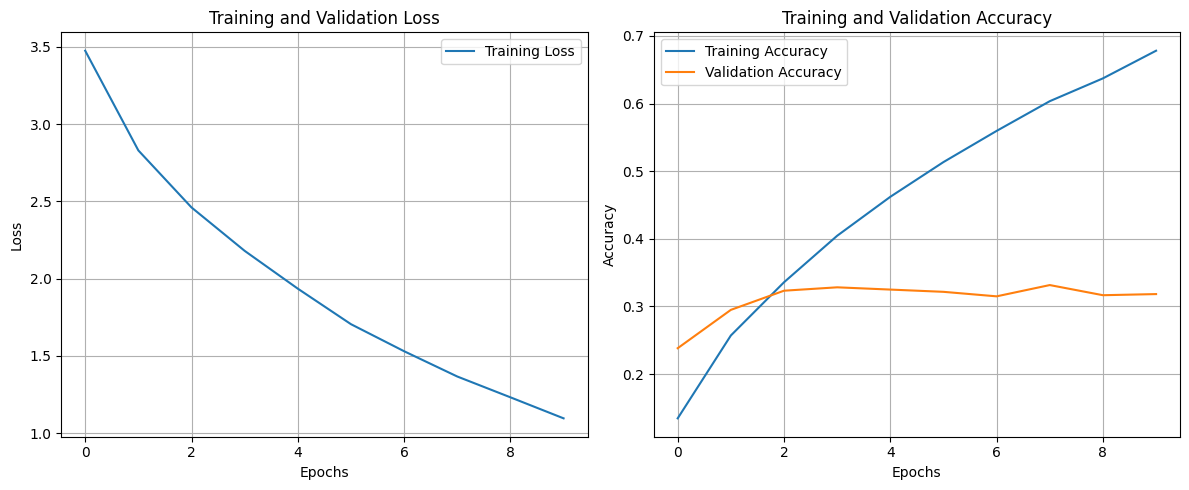

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(H.history['loss'], label='Training Loss')
# plt.plot(H.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [8]:
import tensorflow as tf
import os
import cv2
from skimage import feature
import numpy as np
import torch 
from sklearn.metrics import accuracy_score
from joblib import dump, load
from sklearn.decomposition import PCA
import requests

"""
 Use this cell to test the model. 
 1.Set the path of folder with the test data in path_test
 2.Set the path of label file in path_test_label variable 
 3.Then RUN this cell
 It will show accuracy and also the predictions 
 Assumption: Data in test set is also named as label_image_{some_number} and labels for test set are given in a separate file 
 Just like it was for validation set and training set.
 
"""
# Tester Code

# Load the saved model
loaded_model = tf.keras.models.load_model('flower_model.h5')



# Path of test set 
path_test="C:/samraddh/COLLEGE/sem7/val_data"
# Path of test set labels
path_test_label="C:/samraddh/COLLEGE/sem7/val_labels.txt"


with open(path_test_label) as f:
        test_labels = [word.lower().strip() for word in f.read().split("\n") if word.strip()]

test_labels = [eval(i) for i in test_labels]
list_set = set(test_labels)
corrected_labels = (list(list_set))

X_test_pre=[]
tester_labels=[]

for label in set(corrected_labels):
    
    matching_files = [f for f in os.listdir(path_test) if f.startswith(f"{label}_image_") and f.endswith('.jpg')]
    
    for matching_file in matching_files:
        image_path = os.path.join(path_test, matching_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        (hog, img) = feature.hog(img, orientations=9, 
                pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                block_norm='L2-Hys', visualize=True, transform_sqrt=True)
        X_test_pre.append(img)
        tester_labels.append(label)


X_test_pre=np.array(X_test_pre)

X_test=[]
for (image) in X_test_pre:
        # Flatten the image from (256, 256, 1) to (256*256*1,)
        
        np_array = np.array(image, dtype=np.float32)
        # flattened_image=torch.tensor(np_array)
        flattened_image = np_array.reshape(1,-1)
        
        X_test.append(flattened_image[0])
        

# Getting PCA object
url = 'https://bitspilaniac-my.sharepoint.com/:x:/g/personal/f20211455_pilani_bits-pilani_ac_in/ERdn0AIhmG9Egc1aeBABalwBrJRvJLqMeJ39LvpGYREi3g?download=1'

response = requests.get(url)
if response.status_code == 200:
    with open('pca_object.joblib', 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully!")
else:
    print("Failed to download file. Status code:", response.status_code)

# loadig of pca object 
loaded_pca = load('pca_object.joblib')
X_test = loaded_pca.transform(X_test)

# Predict Using Model
predictions = loaded_model.predict(X_test)

predicted_classes = tf.argmax(predictions, axis=1).numpy()

# adjustment is required because predictions are according to one hot
adjusted_predictions = [pred + 1 for pred in predicted_classes]
    
print(adjusted_predictions)

accuracy = accuracy_score(tester_labels, adjusted_predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

File downloaded successfully!
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
[1, 13, 48, 1, 1, 1, 1, 1, 1, 1, 21, 38, 56, 46, 16, 21, 48, 42, 15, 42, 49, 56, 3, 3, 3, 3, 3, 7, 3, 7, 46, 11, 59, 11, 24, 36, 11, 24, 4, 46, 5, 5, 21, 54, 21, 5, 39, 20, 5, 21, 35, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 30, 3, 9, 60, 12, 44, 3, 43, 43, 8, 3, 19, 8, 6, 55, 8, 10, 8, 8, 9, 24, 24, 52, 31, 9, 35, 9, 24, 24, 10, 9, 10, 10, 10, 10, 35, 6, 10, 10, 31, 55, 11, 11, 11, 47, 16, 26, 24, 55, 12, 6, 12, 12, 12, 31, 12, 12, 12, 12, 18, 46, 22, 31, 13, 56, 36, 56, 58, 55, 30, 47, 49, 56, 24, 22, 18, 22, 14, 4, 15, 21, 59, 5, 15, 33, 15, 15, 2, 15, 24, 44, 16, 57, 11, 16, 46, 16, 21, 24, 17, 17, 27, 36, 25, 17, 17, 45, 31, 59, 19, 18, 29, 18, 38, 14, 14, 18, 54, 18, 19, 22, 24, 26, 19, 49, 11, 14, 39, 8, 7, 20, 20, 51, 22, 26, 22, 36, 53, 59, 35, 9, 21, 21, 21, 15, 21, 15, 15, 30, 24, 24, 4, 24, 34, 24, 24, 19, 24, 55, 23, 23, 54, 20, 27, 28, 50, 23, 23, 13, 57, 39, 7, 51, 24, 57, 57, 46, 11, 24, 9, 11, 15, 49, 25, 25, 2